In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy.random as rd
import time
import pandas as pd

In [33]:
def S(y,x, a):
    return float((y-a.dot(x.T))**2)

def gradS(y,x, a):
    S = []
    for p in range(a.size):
        aux = 0
        aux -= float(x[0][p]) * (y - float(a.dot(x.T)))
        S.append(aux)
    return S

def gradS_reg(y,x, a,lamb):
    S = []
    for p in range(a.size):
        aux = 0
        aux -= float(x[0][p]) * (y - float(a.dot(x.T)))
        S.append(aux)
    return S+list(lamb*2*a*np.linalg.norm(x))

def perte_quadr(M,U,V):
    MM=U.dot(V.T)
    p = 0
    n, m = M.shape
    non_nul=n*m
    for i in range(n):
        for j in range(m):
            if M[i][j]==0:
                non_nul-=1
                continue    # on ne considère que la perte sur le train , c'est à dire sur les facteurs deja rempli
            p += (M[i][j] - MM[i][j]) ** 2
    return p/non_nul

def perte_quadr_reg(M,U,V,lamb):
    MM=U.dot(V.T)
    p = 0
    n, m = M.shape
    for i in range(n):
        for j in range(m):
            if M[i][j]==0:
                continue    # on ne considère que la perte sur le train , c'est à dire sur les facteurs deja rempli
            p += (M[i][j] - MM[i][j]) ** 2
    return p + lamb*(np.linalg.norm(U)+np.linalg.norm(V))


def perte_rapide(M,U,V,i,j):
    MM=U.dot(V.T)
    p = 0
    n, m = M.shape
    for ligne in range(n):
        if M[ligne][j]==0:   #de meme
            continue
        p+=(M[ligne][j] - MM[ligne][j]) ** 2
    for colonne in range(m):
        if M[i][colonne]==0:   #de meme
            continue
        p+=(M[i][colonne] - MM[i][colonne]) ** 2
    return p


def perte_rapide_reg(M,U,V,i,j,lamb):
    MM=U.dot(V.T)
    p = 0
    n, m = M.shape
    for ligne in range(n):
        if M[ligne][j]==0:   #de meme
            continue
        p+=(M[ligne][j] - MM[ligne][j]) ** 2
    for colonne in range(m):
        if M[i][colonne]==0:   #de meme
            continue
        p+=(M[i][colonne] - MM[i][colonne]) ** 2
    return p+ lamb*np.linalg.norm(U)+lamb*np.linalg.norm(V)

In [34]:
def train_and_test(M,x):
    train=np.zeros(M.shape)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            r = rd.random()
            if r >= x:
                train[i][j]=M[i][j]
    test=M-train
    return train, test

In [35]:
def mon_idee_creuse_tres_rapide(M, l, iter, pas, eps, courbes_seulement,lamb):
    # le paramètre courbe_seulement c'est si on veut afficher toutes les étapes ou juste les courbes pour comparer les résultats
    etape, perte_train_etape,perte_test_etape, temps, perte_train_temps, perte_test_temps = [], [], [], [], [], []

    MAT_U = np.array([[.1 for k in range(l)] for k in range(M.shape[0])])
    MAT_V = np.array([[.1 for k in range(l)] for k in range(M.shape[1])])
    L1 = [k for k in range(M.shape[0])]
    L2 = [k for k in range(M.shape[1])]
    rd.shuffle(L1)
    rd.shuffle(L2)
    
    train, test = train_and_test(M,x=0.25) # ensemble de test de taille 25% du dataset total
    
    #enlever les zeros
    paires=[]
    for i in L1:
        for j in L2:
            if train[i][j]!=0:
                paires.append((i,j))

    #if (courbes_seulement == False):
      #  print("Matrice à factoriser :")
      #  print(M)

    debut = time.time()

    for ww in range(iter):
        pas /= 1.1

        for paire in paires:
            n,m = paire
            a = float(train[n][m])
            U = MAT_U[n:n + 1]
            V = MAT_V[m:m + 1]
            e, ee = 0, 0

            # On minismise sur V à U constant
            while e<3:
                gradient = gradS_reg(a, U, V,lamb)
                #if (max(gradient) < eps) and (min(gradient) > -eps):
                    #break
                e += 1
                for i in range(l):
                    p1 = perte_rapide_reg(train, MAT_U,MAT_V,n,m,lamb)
                    grad = gradient[i]
                    V[0][i] -= pas * grad
                    p2 = perte_rapide_reg(train, MAT_U,MAT_V,n,m,lamb)
                    if (p1 < p2):
                        V[0][i] += pas * grad


            MAT_V[m] = V
                # On minimise sur U à V constant
            while ee<3:
                gradient = gradS_reg(a, U, V,lamb)
                #if (max(gradient) < eps) and (min(gradient) > -eps):
                    #break
                ee += 1
                for i in range(l):
                    p1 = perte_rapide_reg(train, MAT_U,MAT_V,n,m,lamb)
                    grad = gradient[i]
                    U[0][i] -= pas * grad
                    p2 = perte_rapide_reg(train,MAT_U,MAT_V,n,m,lamb)
                    if (p1 < p2):
                        U[0][i] += pas * grad

            MAT_U[n] = U

        if (courbes_seulement == False):
            print("etape", ww + 1, "sur", iter)
            
        etape.append(ww)
        perte_train=perte_quadr(train,MAT_U,MAT_V)
        perte_test=perte_quadr(test,MAT_U,MAT_V)
        perte_train_etape.append(perte_train)
        perte_test_etape.append(perte_test)
        temps.append(time.time() - debut)
        perte_train_temps.append(perte_train)
        perte_test_temps.append(perte_test)

    fin = time.time()
    #if (courbes_seulement == False):
       # print(MAT_U.dot(MAT_V.T))
        #print(M)


    ax1 = plt.gca()
    line1, = ax1.plot(etape, perte_train_etape)
    ax2 = ax1.twinx()
    line2, = ax2.plot(etape, perte_test_etape, c='r')
    ax1.set_ylabel("train")
    ax2.set_ylabel("test")
    ax2.legend((line1, line2),
           ("erreur train", "erreur test"))
    ax1.xlabel("Etape")
    plt.show()

In [36]:
#M=np.random.randint(1,6,(10,100))
M=np.array([[5,5,5,5,5,5,5,1,1,1,1,1,1,1],
            [5,5,5,5,5,5,5,1,1,1,1,1,1,1],
            [5,5,5,5,5,5,5,1,1,1,1,1,1,1],
            [5,5,5,5,5,5,5,1,1,1,1,1,1,1],
            [5,5,5,5,5,5,5,1,1,1,1,1,1,1],
            [5,5,5,5,5,5,5,1,1,1,1,1,1,1],
            [5,5,5,5,5,5,5,1,1,1,1,1,1,1],
            [1,1,1,1,1,1,1,5,5,5,5,5,5,5],
            [1,1,1,1,1,1,1,5,5,5,5,5,5,5],
           [1,1,1,1,1,1,1,5,5,5,5,5,5,5],
           [1,1,1,1,1,1,1,5,5,5,5,5,5,5],
           [1,1,1,1,1,1,1,5,5,5,5,5,5,5],
           [1,1,1,1,1,1,1,5,5,5,5,5,5,5],
           [1,1,1,1,1,1,1,5,5,5,5,5,5,5]])
M.shape

(14, 14)

etape 1 sur 10
etape 2 sur 10
etape 3 sur 10
etape 4 sur 10
etape 5 sur 10
etape 6 sur 10
etape 7 sur 10
etape 8 sur 10
etape 9 sur 10
etape 10 sur 10


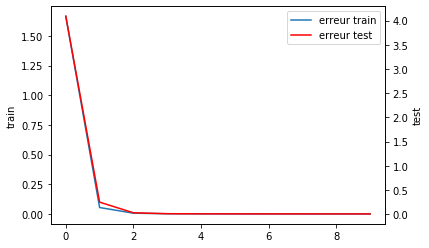

In [37]:
mon_idee_creuse_tres_rapide(M,5,10,.1,.1,False,2)

In [38]:
M=np.array([[5,5,5,5,5,5,5,1,1,1,1,1,1,1],
            [5,5,5,5,5,5,5,1,1,1,1,1,1,1],
            [5,5,5,5,5,5,5,1,1,1,1,1,1,1],
            [5,5,5,5,5,5,5,1,1,1,1,1,1,1],
            [5,5,5,5,5,5,5,1,1,1,1,1,1,1],
            [5,5,5,5,5,5,5,1,1,1,1,1,1,1],
            [5,5,5,5,5,5,5,1,1,1,1,1,1,1],
            [1,1,1,1,1,1,1,5,5,5,5,5,5,5],
            [1,1,1,1,1,1,1,5,5,5,5,5,5,5],
           [1,1,1,1,1,1,1,5,5,5,5,5,5,5],
           [1,1,1,1,1,1,1,5,5,5,5,5,5,5],
           [1,1,1,1,1,1,1,5,5,5,5,5,5,5],
           [1,1,1,1,1,1,1,5,5,5,5,5,5,5],
           [1,1,1,1,1,1,1,5,5,5,5,5,5,5]])

for i in range(len(M)):
    for j in range(len(M[0])):
        if M[i][j]==5:
            M[i][j]=np.random.randint(3,6)   # bonne note devient note entre 3 et 5
        else:
            M[i][j]=np.random.randint(1,3)   # mauvaise note devient note entre 1 et 2
            
print(M)
    

[[4 5 4 4 4 5 4 2 1 1 1 2 2 2]
 [3 3 5 4 4 4 5 2 2 1 1 1 1 2]
 [4 3 4 4 5 3 5 1 2 2 1 1 2 1]
 [4 3 4 3 3 4 5 2 1 1 1 2 2 1]
 [3 5 5 5 5 5 4 1 2 1 1 2 2 2]
 [3 3 5 3 4 5 4 2 2 1 2 1 2 2]
 [3 5 3 3 5 3 5 2 1 1 1 2 1 2]
 [1 1 2 1 2 2 1 3 4 3 3 3 5 4]
 [1 1 2 2 2 1 1 4 5 4 3 4 4 4]
 [2 2 1 1 2 1 2 5 5 3 5 5 5 5]
 [2 2 2 1 1 1 2 4 4 5 5 3 5 5]
 [2 2 2 2 2 2 2 4 4 3 3 5 4 5]
 [2 2 1 1 2 1 2 5 3 4 4 4 4 3]
 [2 2 2 1 1 1 1 4 4 3 3 4 4 3]]


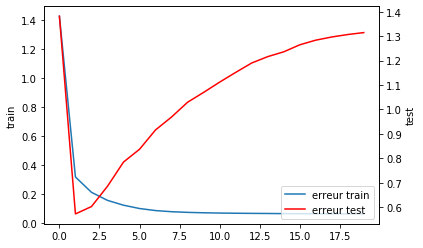

In [39]:
mon_idee_creuse_tres_rapide(M,5,20,.1,.1,True,2)

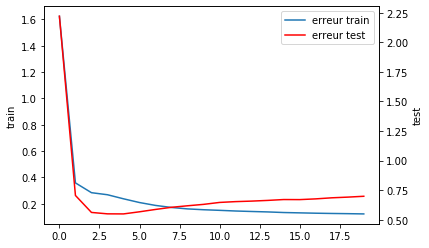

In [40]:
mon_idee_creuse_tres_rapide(M,5,20,.1,.1,True,20)

## On va maintenant essayer sur un vrai dataset


In [41]:
def to_matrice(dataset):
    # marche pour un dataset avec notes entre 0 et note max
    # à adapter sinon
    
    user = dataset.iloc[:, 0]
    item = dataset.iloc[:, 1]

    utile = dataset.iloc[:, 0:3]
    data_array = utile.to_numpy()  # to_numpy devient get_values sur python 3

    user_dict = {}
    for k in range(data_array.shape[0]):
        user_dict[data_array[k][0]] = data_array[k][1]
    nb_user = len(user_dict)

    item_dict = {}
    for k in range(data_array.shape[0]):
        item_dict[data_array[k][1]] = data_array[k][0]
    nb_item = len(item_dict)

    nb_ratings = data_array.shape[0]
    pourc = round(100 * nb_ratings / (nb_user * nb_item), 2)

    print("Il y a ", nb_user, " utilisateurs et ", nb_item, "plats et ", nb_ratings, "notes, soit une matrice ", pourc,
          "% pleine.")

    # Matrice note

    # on commence par remplir une matrice avec que des zeros ou des -1, à voir
    M = np.zeros((nb_user, nb_ratings))

    # Il faut maintenant réindexer
    # Stratégie :

    index = 0
    for cle in user_dict.keys():
        user_dict[cle] = index
        index += 1

    index = 0
    for cle in item_dict.keys():
        item_dict[cle] = index
        index += 1

    for x in data_array:
        user = user_dict.get(x[0])
        item = item_dict.get(x[1])
        rating = x[2]
        M[user][item] = rating + 1  # je fais donc des notes de 1 à 3 et on laisse 0 pour les non notés

    return M

In [43]:
data=to_matrice(pd.read_csv('dataset_restaurant.csv'))

Il y a  138  utilisateurs et  130 plats et  1161 notes, soit une matrice  6.47 % pleine.


etape 1 sur 10
etape 2 sur 10
etape 3 sur 10
etape 4 sur 10
etape 5 sur 10
etape 6 sur 10
etape 7 sur 10
etape 8 sur 10
etape 9 sur 10
etape 10 sur 10


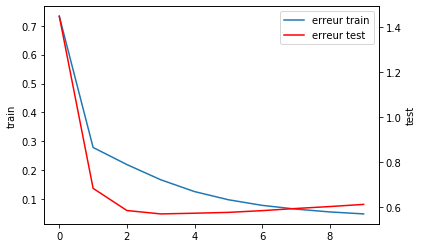

In [44]:
mon_idee_creuse_tres_rapide(data,5,10,.1,.1,False,20)